In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
sns.set()

In [4]:
data = pd.read_pickle('processed_data/simple_filter_11Mar17.pkl')


In [5]:
data.reset_index(drop=True,inplace=True)

In [6]:
data.head()

,Date,Time,Lat,Lon,GPS_Alt,Pressure,Pres_Alt,Temp,Batt,Lat_Delta,Lon_Delta
0,03/11/2017,09:17:03,45.372345,6.574872,1761.7,1.101121e+10,1719.518,21.7,3.906,-0.000004,0.000007
1,03/11/2017,09:17:04,45.372349,6.574866,1763.1,1.101121e+10,1718.728,21.8,3.796,0.000000,0.000004
2,03/11/2017,09:17:05,45.372349,6.574862,1764.2,1.101121e+10,1719.417,21.8,3.796,0.000000,0.000009
3,03/11/2017,09:17:06,45.372349,6.574853,1766.4,1.101121e+10,1721.782,21.7,3.796,-0.000019,0.000017
4,03/11/2017,09:17:07,45.372368,6.574837,1768.6,1.101121e+10,1719.417,21.9,3.790,-0.000023,0.000024


In [7]:
data['gps_alt_roll']=data.GPS_Alt.rolling(400).mean()

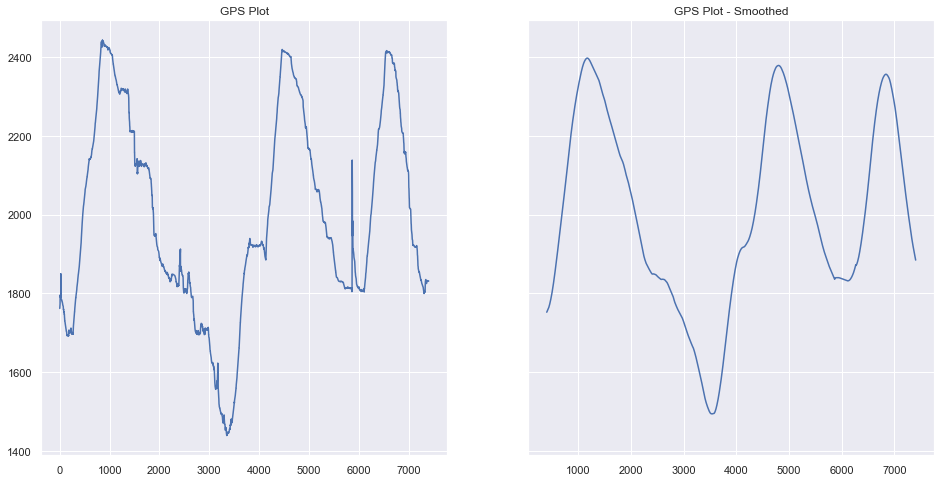

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,8))
data.GPS_Alt.plot(ax=ax1,title='GPS Plot')
data.gps_alt_roll.plot(ax=ax2,title='GPS Plot - Smoothed')


In [9]:
data['gps_alt_roll_delta'] = data.gps_alt_roll[:-1] - data.gps_alt_roll[1:].values
data['gps_alt_raw_delta'] = data.GPS_Alt[:-1] - data.GPS_Alt[1:].values

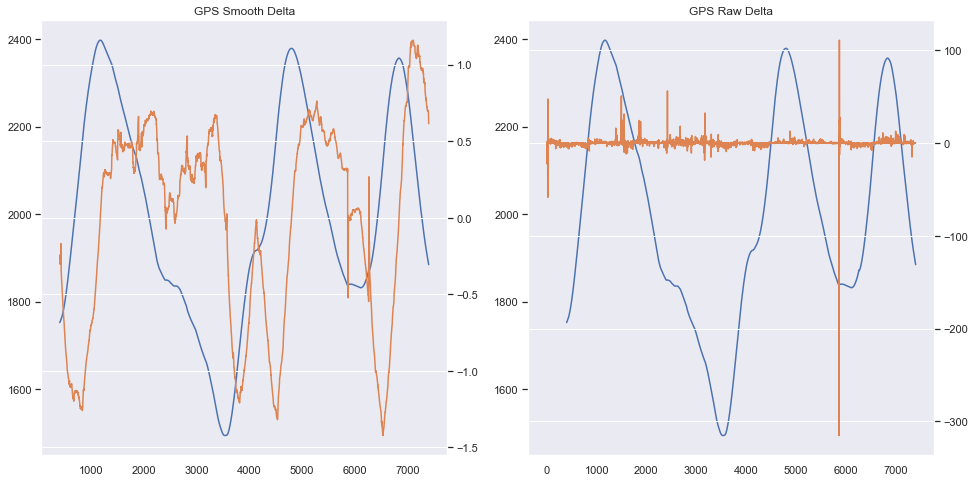

In [10]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))
data.gps_alt_roll.plot(ax=ax[0],title='GPS Smooth Delta')
data.gps_alt_roll_delta.plot(ax=ax[0],secondary_y=True)
data.gps_alt_roll.plot(ax=ax[1],title='GPS Raw Delta')
data.gps_alt_raw_delta.plot(ax=ax[1],secondary_y=True)

In [14]:
#data['gps_alt_roll_delta_roll_delta'] = data.gps_alt_roll_delta_roll[:-1] - data.gps_alt_roll_delta_roll[1:].values
#data['gps_alt_roll_delta_roll_delta_roll'] =data.gps_alt_roll_delta_roll_delta.rolling(240).mean()

#data['gps_alt_raw_delta_roll_delta'] = data.gps_alt_raw_delta_roll[:-1] - data.gps_alt_raw_delta_roll[1:].values
#data['gps_alt_raw_delta_roll_delta_roll'] =data.gps_alt_raw_delta_roll_delta.rolling(240).mean()

data['gps_alt_raw_delta_roll'] =data.gps_alt_raw_delta.rolling(180).mean()
data['gps_alt_roll_delta_roll'] =data.gps_alt_roll_delta.rolling(180).mean()

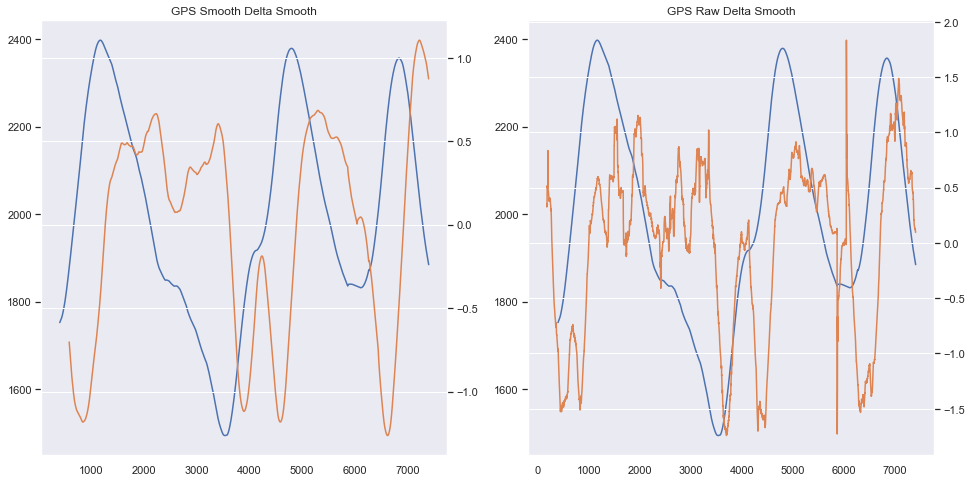

In [15]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))
data.gps_alt_roll.plot(ax=ax[0],title='GPS Smooth Delta Smooth')
data.gps_alt_roll_delta_roll.plot(ax=ax[0],secondary_y=True)
data.gps_alt_roll.plot(ax=ax[1],title='GPS Raw Delta Smooth')
data.gps_alt_raw_delta_roll.plot(ax=ax[1],secondary_y=True)

In [16]:
signs = np.sign(data.gps_alt_raw_delta_roll.fillna(0))
signchange = ((np.roll(signs, 1) - signs) != 0).astype(int)

In [17]:
sign_changes_idx = signchange.index[signchange == 1].tolist()

In [18]:
routes_list=[]
for i in range(len(sign_changes_idx)-1):
    #print(sign_changes_idx[i],sign_changes_idx[i+1]-1, signs[sign_changes_idx[i]])
    start = sign_changes_idx[i]
    end = sign_changes_idx[i+1]-1
    sign = signs[sign_changes_idx[i]]
    max_val = np.max(data.loc[start:end,('gps_alt_raw_delta_roll')])
    routes_list.append((start,end,sign,max_val ))
    
routes = pd.DataFrame(routes_list,columns=['start_idx','end_idx','sign','peak'])
routes.head()

,start_idx,end_idx,sign,peak
0,179,279,1.0,0.836111
1,280,1002,-1.0,-0.000556
2,1003,1357,1.0,0.598889
3,1358,1372,-1.0,-0.000556
4,1373,1682,1.0,1.119444


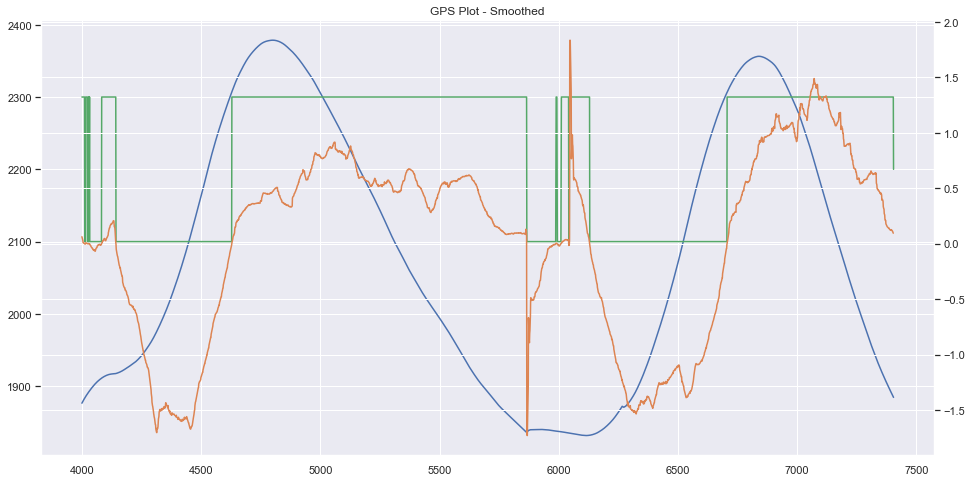

In [19]:
small_data =data.loc[4000:9000]
small_signs = signs.loc[4000:9000] *100 +2200
fig, ax= plt.subplots(1, 1, figsize=(16,8))
small_data.gps_alt_roll.plot(ax=ax,title='GPS Plot - Smoothed')
small_data.gps_alt_raw_delta_roll.plot(ax=ax,secondary_y=True)
small_signs.plot(ax=ax)

In [20]:
peak_filter = 0.5
runs = routes[(routes.sign== 1) & (routes.peak >= peak_filter)].copy()
runs.reset_index(inplace=True)
runs.shape

(9, 5)

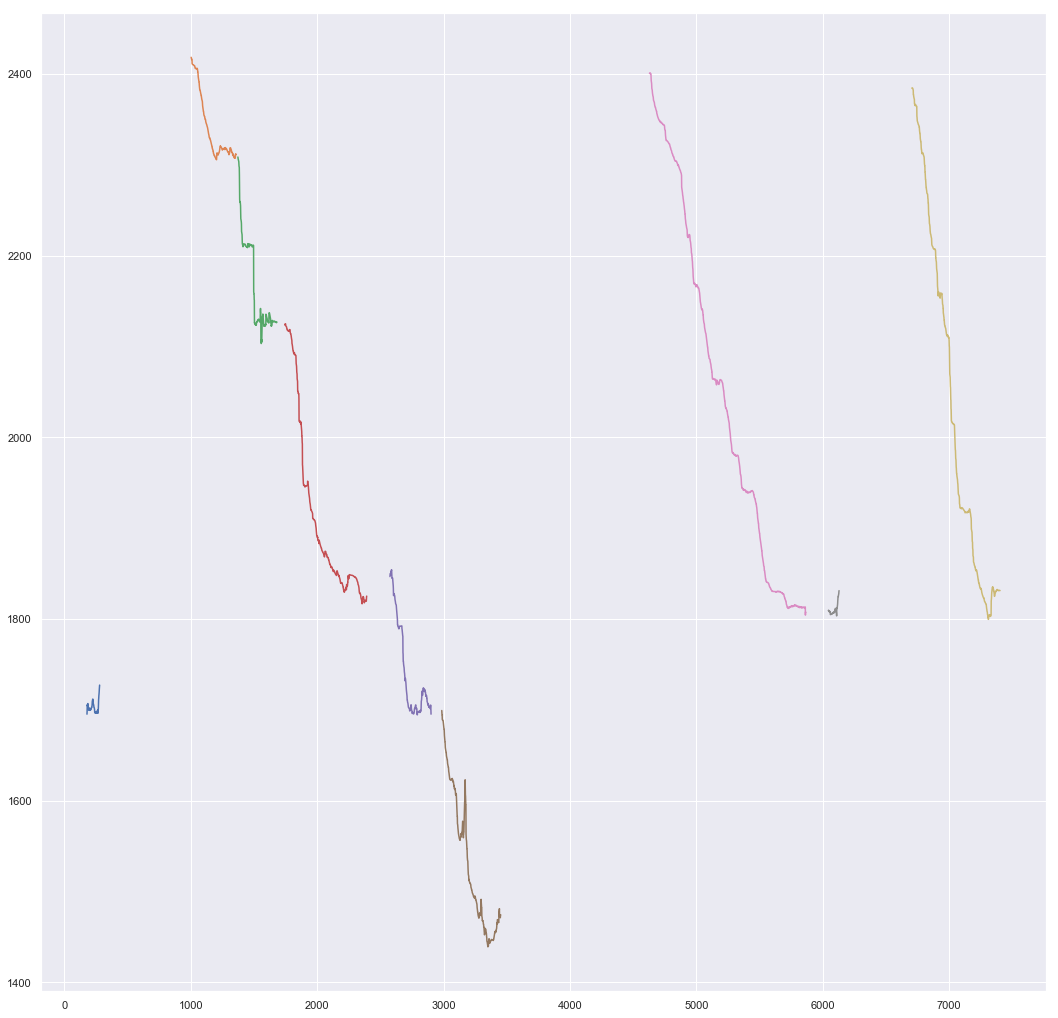

In [22]:
fig, axes= plt.subplots(1,1, figsize=(18,18))
#axes = axes.reshape(1,-1)[0]
for i in range(9):
    start  =np.int(runs.loc[i].start_idx)
    end =  np.int(runs.loc[i].end_idx)
    #print(start, end)
    data.loc[start:end,('GPS_Alt')].plot(ax=axes)

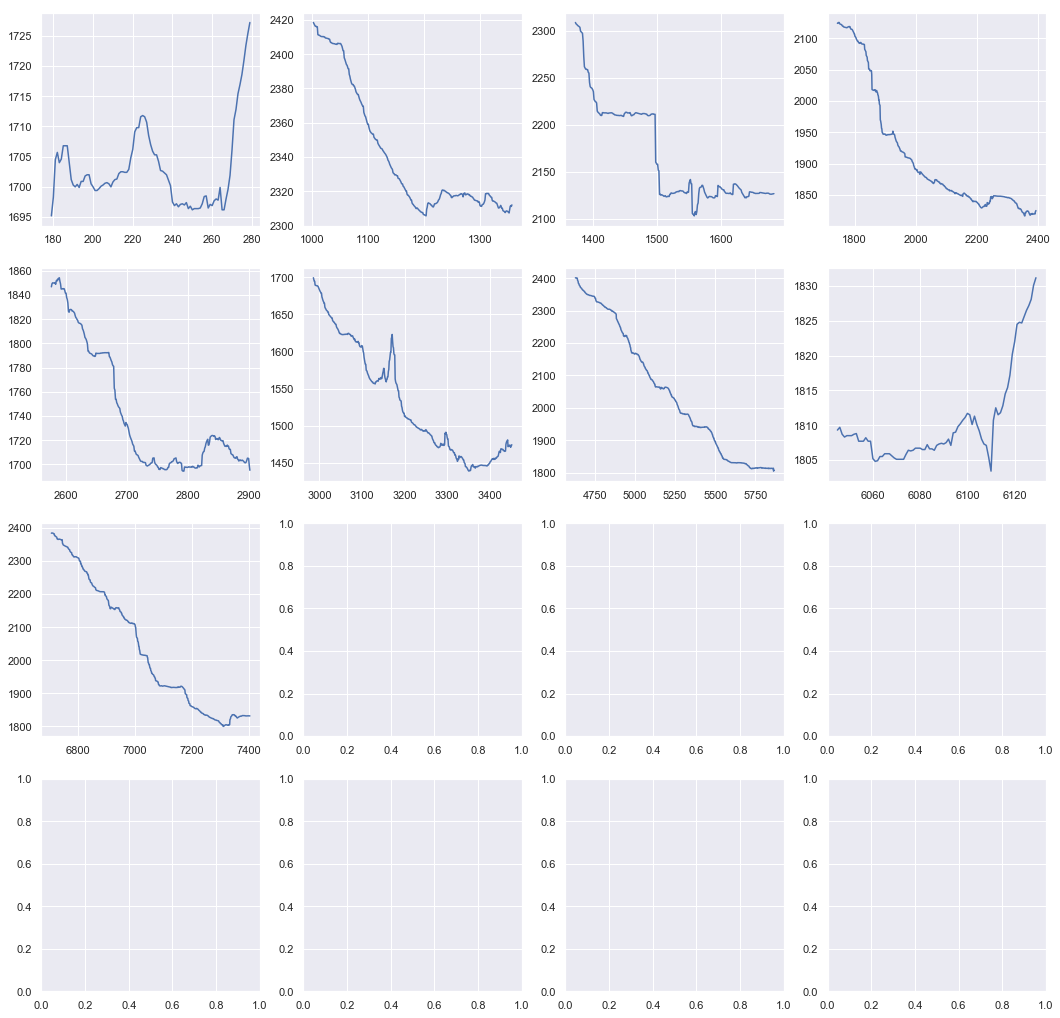

In [23]:
fig, axes= plt.subplots(4, 4, figsize=(18,18))
axes = axes.reshape(1,-1)[0]
for i in range(9):
    start  =np.int(runs.loc[i].start_idx)
    end =  np.int(runs.loc[i].end_idx)
    #print(start, end)
    data.loc[start:end,('GPS_Alt')].plot(ax=axes[i])

In [16]:
json_values = values.to_dict(orient='records')

In [19]:
json_values[0:3]

[{'x': 45.015327, 'y': 6.1279969, 'z': 1686.2},
 {'x': 45.015335, 'y': 6.1279974, 'z': 1685.6},
 {'x': 45.015339, 'y': 6.1279922, 'z': 1685.6}]

In [20]:
with open('json_14Mar18.json','w') as f:
    json.dump(json_values,f)

In [57]:
#single run
with open('json_14Mar18_single.json','w') as f:
    json.dump(json_values[4000:6000],f)